# Run level 2A, 2B and 3 pipelines on IMA data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) April 18th 2018

This notebook demonstrates the execution of the level 2A, 2B and 3 pipelines for IMA data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. 

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))
input_files = sorted(input_files)

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     100   ()      
  1  SCI           1 ImageHDU        62   (1032, 1024, 50, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 50, 2)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 50, 2)   float32   
  5  REFOUT        1 ImageHDU        12   (258, 1024, 50, 2)   float32   
  6  PIXELDQ_DEF    1 BinTableHDU     17   31R x 4C   [J, J, 40A, 128A]   
  7  ASDF          1 AsdfHDU          8   (105680712,)      


#### show the last frame of the first integration for each file

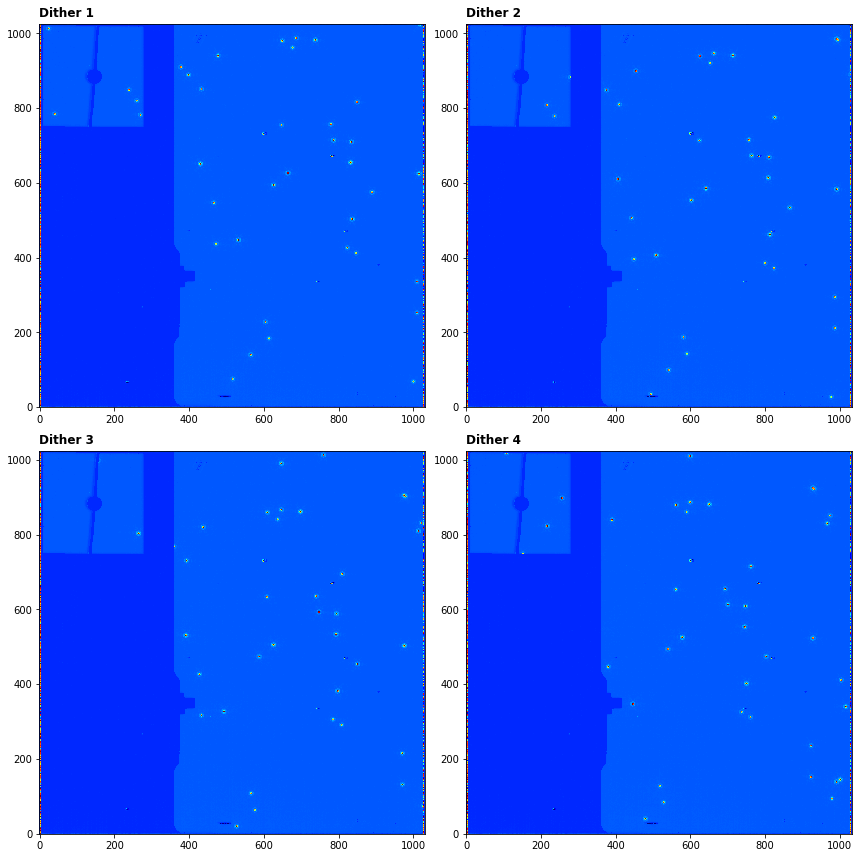

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:
        
        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=3e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### update observation metadata
Before begginning, we need to add some observation/visit related metadata that is not yet included by MIRISim but is required by Image3Pipeline. 

In [5]:
for n, f in enumerate(input_files):
    with datamodels.open(f) as dm:
        # edit the observation keywords and save
        dm.meta.observation.program_number = '12345'
        dm.meta.observation.observation_number = '001'
        dm.meta.observation.visit_number = '001'
        dm.meta.observation.visit_group = '01'
        dm.meta.observation.sequence_id = '1'
        dm.meta.observation.activity_id = '01'

        exp_num = n + 1
        dm.meta.observation.exposure_number = format(exp_num, '05d')

        dm.save(os.path.join(input_dir, dm.meta.filename))

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [6]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'


In [7]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True}})
    

2018-04-18 16:53:06,460 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2018-04-18 16:53:06,462 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2018-04-18 16:53:06,465 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2018-04-18 16:53:06,467 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2018-04-18 16:53:06,469 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2018-04-18 16:53:06,472 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2018-04-18 16:53:06,474 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2018-04-18 16:53:06,477 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2018-04-18 16:53:06,479 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2018-04-18 16:53:06,482 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2018-

2018-04-18 16:54:20,111 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<jwst.datamodels.ramp.RampModel object at 0x194c010da0>,).
2018-04-18 16:54:20,151 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2018-04-18 16:54:20,160 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2018-04-18 16:54:20,222 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2018-04-18 16:54:21,220 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2018-04-18 16:54:21,811 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2018-04-18 16:54:24,697 - stpipe.Detector1Pipeline.jump - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopoi

2018-04-18 16:58:48,000 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2018-04-18 16:58:48,001 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2018-04-18 16:58:48,003 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits'.
2018-04-18 16:58:48,004 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2018-04-18 16:58:48,005 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2018-04-18 16:58:48,005 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2018-04-18 16:58:48,006 - stpipe.Detector1Pipeline

2018-04-18 17:00:23,821 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2018-04-18 17:00:23,821 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2018-04-18 17:00:23,825 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all final reads flagged as DO_NOT_USE.
2018-04-18 17:00:23,839 - stpipe.Detector1Pipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2018-04-18 17:01:57,674 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:475: RuntimeWarning: divide by zero encountered in true_divide
  var_poisson = sum_p / (sum_wgt_p * nsegs_pix)

2018-04-18 17:01:57,675 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:475: RuntimeWarning: invalid value

2018-04-18 17:04:53,384 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2018-04-18 17:04:53,384 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2018-04-18 17:04:53,385 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('IMA_demo_data/det_image_3_MIRIMAGE_F1130Wexp1.fits',).
2018-04-18 17:04:53,387 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2018-04-18 17:04:53,791 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<jwst.datamodels.ramp.RampModel object at 0x1a0bde2080>,).
2018-04-18 17:04:53,829 - stpipe.Detector1Pipeline.group_scale - WARNING - NFRAMES=1 is a power of 2
2018-04-18 17:04:53,830 - stpipe.Detector1Pipeline.group_scale - WARNING - Step will be skipped
2018-04-18 17:04:53,833 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2018-04-18 17:04:53,898 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_

2018-04-18 17:08:35,708 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:485: RuntimeWarning: invalid value encountered in true_divide
  sum_r = (segments*var_r[:]/((nsegs_pix)**3.)).sum(axis=0)

2018-04-18 17:08:35,860 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:489: RuntimeWarning: divide by zero encountered in true_divide
  var_readnoise = sum_r/nsegs_pix

2018-04-18 17:08:35,861 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:489: RuntimeWarning: invalid value encountered in true_divide
  var_readnoise = sum_r/nsegs_pix

2018-04-18 17:10:28,972 - stpipe.Detecto

2018-04-18 17:11:24,968 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<jwst.datamodels.ramp.RampModel object at 0x181d000b70>,).
2018-04-18 17:11:24,970 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2018-04-18 17:11:24,973 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done
2018-04-18 17:11:25,060 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<jwst.datamodels.ramp.RampModel object at 0x181d000b70>,).
2018-04-18 17:11:25,109 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits
2018-04-18 17:11:27,388 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2018-04-18 17:11:27,467 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<jwst.datamodels.ramp.RampModel object at 0x181d26f7f0>,).
2018-04-18 17:11:27,507 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/pa

2018-04-18 17:17:01,101 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 50
2018-04-18 17:17:01,102 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2018-04-18 17:17:01,470 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2018-04-18 17:17:01,648 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<jwst.datamodels.image.ImageModel object at 0x181d176278>,).
2018-04-18 17:17:01,728 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2018-04-18 17:17:01,730 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2018-04-18 17:17:01,734 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2018-04-18 17:17:01,821 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<jwst.datamodels.cube.CubeModel object at 0x19b8a73c18>,).
2018-04-18 17:17:01,904 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT no

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [8]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [9]:
from jwst.pipeline import Image2Pipeline
print(Image2Pipeline.__doc__)


    Image2Pipeline: Processes JWST imaging-mode slope data from Level-2a to
    Level-2b.

    Included steps are:
    background_subtraction, assign_wcs, flat_field, photom and resample.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Currently MIRISim is assigning an incorret value of 4 to the wcsaxes keyword in the datamodels. This is due to issues with displaying MIRISim output in applications like ds9. However, the incorrect value will cause an error at the level 3 stage in the resample step, which expects wcsaxes=2 for images. Therefore, we manually set wcsaxes to 2 in the call to Image2Pipeline so it propagates into the cal.fits output.

In [10]:
for f in level2A_files:
    with datamodels.open(f) as dm:
        dm.meta.wcsinfo.wcsaxes = 2
        Image2Pipeline.call(dm, output_use_model=True, save_results=True, output_dir=output_dir)
    

2018-04-18 17:17:02,590 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2018-04-18 17:17:02,592 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2018-04-18 17:17:02,594 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2018-04-18 17:17:02,597 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2018-04-18 17:17:02,599 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2018-04-18 17:17:02,601 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2018-04-18 17:17:02,779 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2018-04-18 17:17:02,781 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2018-04-18 17:17:02,782 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2018-04-18 17:17:02,782 - stpipe

2018-04-18 17:17:07,174 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2018-04-18 17:17:07,175 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2018-04-18 17:17:07,175 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2018-04-18 17:17:07,176 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2018-04-18 17:17:07,177 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf'.
2018-04-18 17:17:07,178 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2018-04-18 17:17:07,179 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2018-04-18 17:17:07,180 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/Users/pa

2018-04-18 17:17:11,375 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2018-04-18 17:17:11,375 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_filteroffset_0003.asdf'.
2018-04-18 17:17:11,376 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat_0123.fits'.
2018-04-18 17:17:11,377 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2018-04-18 17:17:11,378 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2018-04-18 17:17:11,379 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2018-04-18 17:17:11,379 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2018-04-18 17:17:11,380 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2018-04-18 17:17:11

2018-04-18 17:17:15,630 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2018-04-18 17:17:15,631 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2018-04-18 17:17:15,631 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2018-04-18 17:17:15,632 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2018-04-18 17:17:15,633 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits'.
2018-04-18 17:17:15,634 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2018-04-18 17:17:15,635 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2018-04-18 17:17:15,636 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2018-04-18 17:17:15,636 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N

#### Quick check of the pipeline steps applied in the level 2B output. We'll look at the first dither:

In [11]:
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

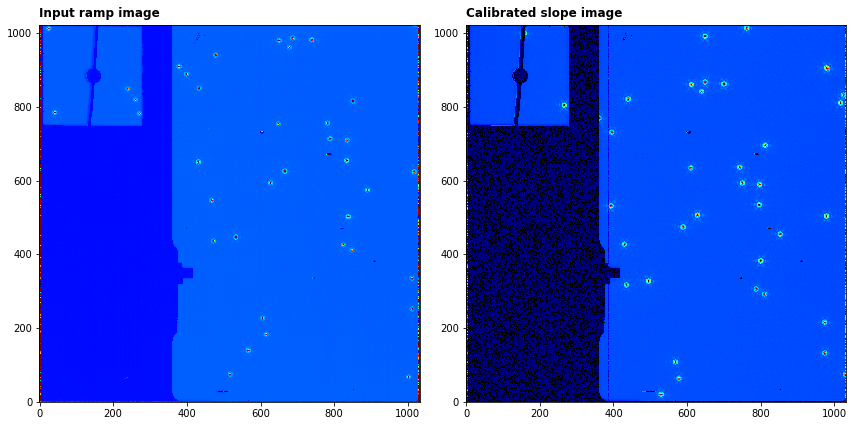

In [12]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=2e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=2, vmax=100))
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

### Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline. We can then combine the dithers with the Image3Pipeline. Note the the image alignment step tweakreg is not working in jwst-0.9.2. Therefore, we skip this step. 

We also skip the skymatch step as it seems to determine a large sky background from the images which, when subtracted, results in the majorit of pixels in the FOV having negative values.

The output drizzled image file will be contained in '*_i2d.fits' with the source list contained in '*_cat.ecsv'. The source detection does not work terribly well at the moment, detecting many spurios sources in the spokes of the PSF and around edges. One can play with the detection parameters to help.

The are also some issues with saving files in the ouput_dir. If the output of outlier_detection is saved there, the resample step can't find them. Therefore, we save everything in the working directory and move them to output_dir after running the pipeline. Note also that the i2d.fits and .ecsv output are not saved with a filename from the association but rather the root of the filename is one of the dithers. We will rename these files.

#### create the level 3 association using the asn_from_list tool

In [13]:
#for n,cal_file in enumerate(cal_files): cal_files[n] = os.path.basename(cal_file)
call(["asn_from_list", "-o", "IMA_asn.json"] + level2B_files + ["--product-name", "ima_dither"])


0

#### import the level 3 pipeline class and print description

In [14]:
from jwst.pipeline import Image3Pipeline
print(Image3Pipeline.__doc__)


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


#### run pipeline

In [15]:
dm_3_container = datamodels.ModelContainer("IMA_asn.json")

Image3Pipeline.call(dm_3_container, save_results=True, steps={'tweakreg':{'skip':True}, 'skymatch':{'skip':True}})

2018-04-18 17:17:23,911 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2018-04-18 17:17:23,914 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2018-04-18 17:17:23,918 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2018-04-18 17:17:23,921 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2018-04-18 17:17:23,924 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2018-04-18 17:17:23,927 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2018-04-18 17:17:24,715 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2018-04-18 17:17:25,303 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2018-04-18 17:17:25,900 - s

2018-04-18 17:17:52,574 - stpipe.Image3Pipeline - INFO - Saved model in ima_dither_i2d.fits
2018-04-18 17:17:52,575 - stpipe.Image3Pipeline - INFO - Creating source catalog...
2018-04-18 17:17:52,699 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<jwst.datamodels.drizproduct.DrizProductModel object at 0x1815787278>,).
2018-04-18 17:17:55,296 - stpipe.Image3Pipeline.source_catalog - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/astropy/io/fits/card.py:979: VerifyWarning: Card is too long, comment will be truncated.
  VerifyWarning)

2018-04-18 17:17:55,306 - stpipe.Image3Pipeline.source_catalog - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (3) than the image it is associated with (2)
  wcsprm.naxis, header_naxis), FITSFixedWarning)

2018-04-18 17:17:55,363 - stpipe.Image3Pipeline.source_cata

In [16]:
# move the Image3Pipeline output to the output_dir
try:
    for file in glob.glob('*crf.fits'): shutil.move(file,os.path.join(output_dir,file))
except:
    pass
try:
    for file in glob.glob('*i2d.fits'): shutil.move(file,os.path.join(output_dir,'ima_dither_i2d.fits'))
except:
    pass
try:
    shutil.move('IMA_asn.json',os.path.join(output_dir,'IMA_asn.json'))
except:
    pass
try:
    for file in glob.glob('*.ecsv'): shutil.move(file,os.path.join(output_dir,'ima_dither_cat.ecsv'))
except:
    pass

#### plot the drizzled file

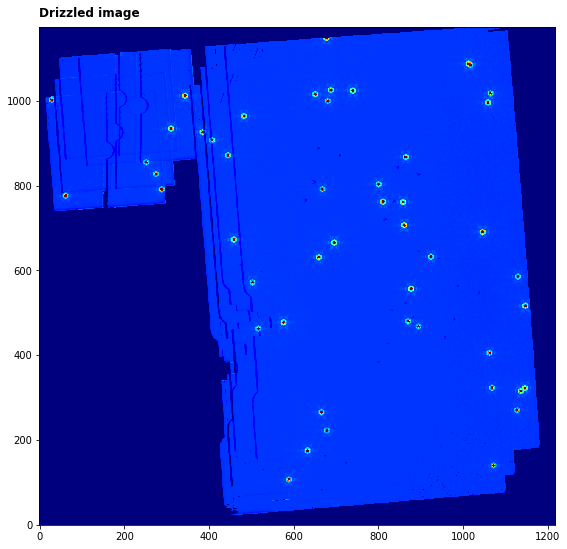

In [17]:
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1,vmax=20)
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

#### look at the source list 

In [18]:
from astropy.table import Table

my_catalog = os.path.join(output_dir,'ima_dither_cat.ecsv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print(sources.columns)    # print all available column names
print()
sources['id', 'xcentroid', 'ycentroid', 'sky_centroid', 'abmag'].pprint(max_width=200)

<TableColumns names=('id','xcentroid','ycentroid','sky_centroid','area','source_sum','source_sum_err','semimajor_axis_sigma','semiminor_axis_sigma','orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur','orientation_sky','abmag','abmag_error')>

 id     xcentroid          ycentroid                    sky_centroid                     abmag       
           pix                pix                         deg,deg                                    
--- ------------------ ------------------ ---------------------------------------- ------------------
  1  693.6162995368477  46.77057719874218 359.97884046573125,0.0014483417666765997 18.411598205566406
  2  706.2670327616507  47.45862169993468  359.9784523026348,0.0014696483973439466 18.721242904663086
  3  552.3066770442849  57.50344810650228  359.9831762762503,0.0017807060055452793 18.967182159423828
  4  587.1506889538891  60.44469144845041  359.9821071555952,0.0018717873101113723  19.06737518310547
  5  588.4036450263609 10

#### plot the source list over the drizzled image

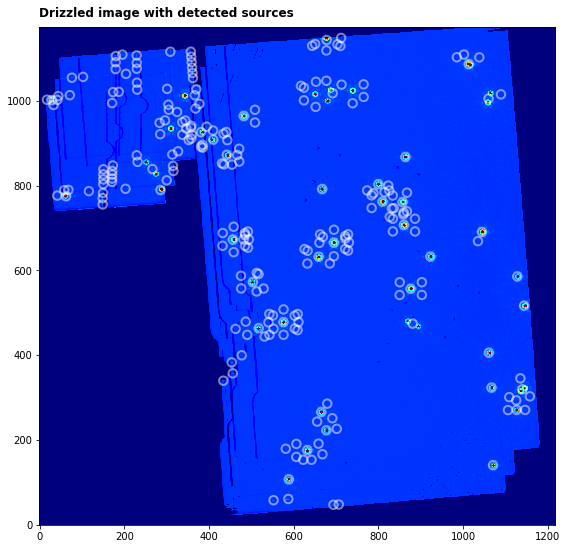

In [19]:
from astropy.table import Table
from photutils import CircularAperture

# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=10.)

# image
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=20)
apertures.plot(color='white', lw=2.0, alpha=0.5)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()